In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-09-25 22:09:55--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.3.176, 172.217.14.208, 172.217.14.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.3.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.02s   

2020-09-25 22:09:55 (3.77 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



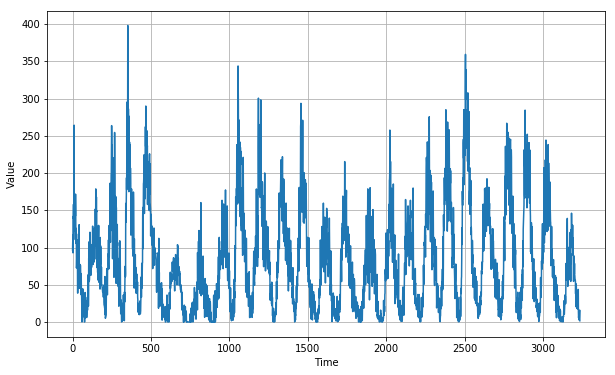

In [4]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

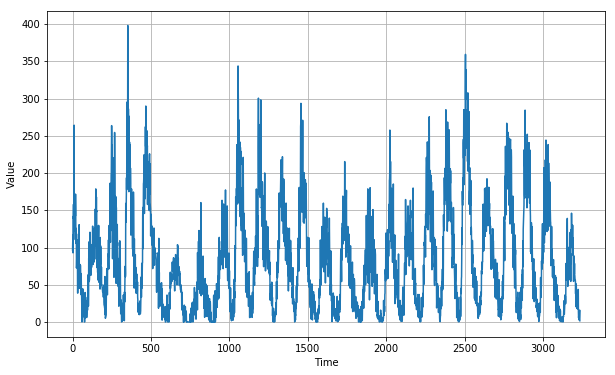

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 5s 379ms/step - loss: 80.2708 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 2s 195ms/step - loss: 78.2509 - mae: 78.5896
Epoch 3/100
12/12 [==============================] - 2s 193ms/step - loss: 75.6613 - mae: 75.9445
Epoch 4/100
12/12 [==============================] - 2s 199ms/step - loss: 72.3021 - mae: 72.7693
Epoch 5/100
12/12 [==============================] - 2s 191ms/step - loss: 69.0173 - mae: 69.2661
Epoch 6/100
12/12 [==============================] - 2s 195ms/step - loss: 65.3797 - mae: 65.6140
Epoch 7/100
12/12 [==============================] - 2s 192ms/step - loss: 61.9061 - mae: 62.0189
Epoch 8/100
12/12 [==============================] - 2s 191ms/step - loss: 58.0653 - mae: 58.6465
Epoch 9/100
12/12 [==============================] - 2s 198ms/step - loss: 55.4543 - mae: 55.5682
Epoch 10/100
12/

12/12 [==============================] - 2s 203ms/step - loss: 27.1983 - mae: 27.8086
Epoch 83/100
12/12 [==============================] - 2s 203ms/step - loss: 54.6648 - mae: 55.1151
Epoch 84/100
12/12 [==============================] - 2s 197ms/step - loss: 48.2799 - mae: 48.8510
Epoch 85/100
12/12 [==============================] - 2s 207ms/step - loss: 38.2064 - mae: 38.5074
Epoch 86/100
12/12 [==============================] - 2s 200ms/step - loss: 45.2375 - mae: 45.8086
Epoch 87/100
12/12 [==============================] - 2s 207ms/step - loss: 29.8813 - mae: 30.6106
Epoch 88/100
12/12 [==============================] - 2s 201ms/step - loss: 40.9649 - mae: 41.8156
Epoch 89/100
12/12 [==============================] - 2s 207ms/step - loss: 30.9045 - mae: 31.0554
Epoch 90/100
12/12 [==============================] - 2s 201ms/step - loss: 26.9683 - mae: 27.0029
Epoch 91/100
12/12 [==============================] - 3s 210ms/step - loss: 28.8902 - mae: 29.4234
Epoch 92/100
12/12 [===

[1e-08, 0.0001, 0, 60]

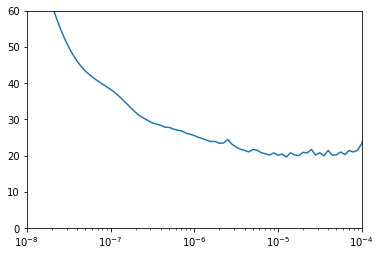

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 4s 131ms/step - loss: 37.8969 - mae: 38.6062
Epoch 2/500
30/30 [==============================] - 2s 66ms/step - loss: 24.0752 - mae: 24.6120
Epoch 3/500
30/30 [==============================] - 2s 69ms/step - loss: 22.0253 - mae: 22.5215
Epoch 4/500
30/30 [==============================] - 2s 65ms/step - loss: 19.8250 - mae: 20.3083
Epoch 5/500
30/30 [==============================] - 2s 69ms/step - loss: 19.4588 - mae: 19.9468
Epoch 6/500
30/30 [==============================] - 2s 70ms/step - loss: 19.2230 - mae: 19.7194
Epoch 7/500
30/30 [==============================] - 2s 66ms/step - loss: 18.6189 - mae: 19.0873
Epoch 8/500
30/30 [==============================] - 2s 65ms/step - loss: 18.4368 - mae: 18.9495
Epoch 9/500
30/30 [==============================] - 2s 65ms/step - loss: 18.2538 - mae: 18.7017
Epoch 10/500
30/30 [==============================] - 2s 63ms/step - loss: 18.7981 - mae: 19.2850
Epoch 11/500
30/30 [========

30/30 [==============================] - 2s 69ms/step - loss: 16.4316 - mae: 16.9101
Epoch 85/500
30/30 [==============================] - 2s 73ms/step - loss: 16.4675 - mae: 16.9538: 1s - loss: 1
Epoch 86/500
30/30 [==============================] - 2s 67ms/step - loss: 16.3868 - mae: 16.8653
Epoch 87/500
30/30 [==============================] - 2s 66ms/step - loss: 16.5435 - mae: 17.0175
Epoch 88/500
30/30 [==============================] - 2s 67ms/step - loss: 16.4174 - mae: 16.8724
Epoch 89/500
30/30 [==============================] - 2s 66ms/step - loss: 16.3590 - mae: 16.8517
Epoch 90/500
30/30 [==============================] - 2s 69ms/step - loss: 16.3706 - mae: 16.8695
Epoch 91/500
30/30 [==============================] - 2s 73ms/step - loss: 16.3702 - mae: 16.8553
Epoch 92/500
30/30 [==============================] - 2s 78ms/step - loss: 16.3611 - mae: 16.8337
Epoch 93/500
30/30 [==============================] - 2s 67ms/step - loss: 16.3336 - mae: 16.8109
Epoch 94/500
30/30 

30/30 [==============================] - 2s 72ms/step - loss: 16.0086 - mae: 16.5157
Epoch 167/500
30/30 [==============================] - 2s 70ms/step - loss: 15.7946 - mae: 16.2804
Epoch 168/500
30/30 [==============================] - 2s 73ms/step - loss: 15.8285 - mae: 16.2992: 0s - loss: 15.5725 - ma
Epoch 169/500
30/30 [==============================] - 2s 69ms/step - loss: 15.8374 - mae: 16.3139
Epoch 170/500
30/30 [==============================] - 2s 70ms/step - loss: 15.7977 - mae: 16.2966
Epoch 171/500
30/30 [==============================] - 2s 72ms/step - loss: 15.8146 - mae: 16.2946
Epoch 172/500
30/30 [==============================] - 2s 69ms/step - loss: 15.7302 - mae: 16.2102
Epoch 173/500
30/30 [==============================] - 2s 71ms/step - loss: 15.7551 - mae: 16.2517
Epoch 174/500
30/30 [==============================] - 2s 69ms/step - loss: 15.8589 - mae: 16.3473
Epoch 175/500
30/30 [==============================] - 2s 69ms/step - loss: 15.7915 - mae: 16.2747

30/30 [==============================] - 2s 70ms/step - loss: 15.3100 - mae: 15.7854
Epoch 249/500
30/30 [==============================] - 2s 73ms/step - loss: 15.3957 - mae: 15.8609
Epoch 250/500
30/30 [==============================] - 2s 69ms/step - loss: 15.5722 - mae: 16.0574
Epoch 251/500
30/30 [==============================] - 2s 74ms/step - loss: 15.3184 - mae: 15.8367
Epoch 252/500
30/30 [==============================] - 2s 70ms/step - loss: 15.3438 - mae: 15.8476
Epoch 253/500
30/30 [==============================] - 2s 70ms/step - loss: 15.2665 - mae: 15.7545
Epoch 254/500
30/30 [==============================] - 2s 71ms/step - loss: 15.3370 - mae: 15.8173
Epoch 255/500
30/30 [==============================] - 2s 71ms/step - loss: 15.2363 - mae: 15.7622
Epoch 256/500
30/30 [==============================] - 2s 75ms/step - loss: 15.2386 - mae: 15.7231
Epoch 257/500
30/30 [==============================] - 3s 92ms/step - loss: 15.2542 - mae: 15.7171
Epoch 258/500
30/30 [===

30/30 [==============================] - 2s 65ms/step - loss: 14.9737 - mae: 15.4661
Epoch 331/500
30/30 [==============================] - 2s 67ms/step - loss: 14.9616 - mae: 15.4623
Epoch 332/500
30/30 [==============================] - 2s 69ms/step - loss: 14.8826 - mae: 15.3741
Epoch 333/500
30/30 [==============================] - 2s 71ms/step - loss: 14.8728 - mae: 15.3647
Epoch 334/500
30/30 [==============================] - 2s 72ms/step - loss: 14.8502 - mae: 15.3189
Epoch 335/500
30/30 [==============================] - 2s 72ms/step - loss: 14.8444 - mae: 15.3431
Epoch 336/500
30/30 [==============================] - 2s 70ms/step - loss: 14.8302 - mae: 15.3195
Epoch 337/500
30/30 [==============================] - 2s 67ms/step - loss: 14.8599 - mae: 15.3416
Epoch 338/500
30/30 [==============================] - 2s 70ms/step - loss: 14.8718 - mae: 15.3905
Epoch 339/500
30/30 [==============================] - 2s 68ms/step - loss: 14.9384 - mae: 15.3902
Epoch 340/500
30/30 [===

30/30 [==============================] - 2s 77ms/step - loss: 14.6195 - mae: 15.1024
Epoch 413/500
30/30 [==============================] - 2s 70ms/step - loss: 14.5588 - mae: 15.0427
Epoch 414/500
30/30 [==============================] - 2s 76ms/step - loss: 14.4490 - mae: 14.9333
Epoch 415/500
30/30 [==============================] - 3s 86ms/step - loss: 14.4194 - mae: 14.9238
Epoch 416/500
30/30 [==============================] - 3s 87ms/step - loss: 14.4906 - mae: 14.9590
Epoch 417/500
30/30 [==============================] - 2s 70ms/step - loss: 15.1896 - mae: 15.6862
Epoch 418/500
30/30 [==============================] - 2s 73ms/step - loss: 15.3542 - mae: 15.8543
Epoch 419/500
30/30 [==============================] - 2s 69ms/step - loss: 14.6294 - mae: 15.1424
Epoch 420/500
30/30 [==============================] - 2s 69ms/step - loss: 14.4008 - mae: 14.8917
Epoch 421/500
30/30 [==============================] - 2s 69ms/step - loss: 14.4226 - mae: 14.9032
Epoch 422/500
30/30 [===

30/30 [==============================] - 2s 78ms/step - loss: 14.3039 - mae: 14.8066
Epoch 495/500
30/30 [==============================] - 2s 70ms/step - loss: 14.0361 - mae: 14.5256
Epoch 496/500
30/30 [==============================] - 2s 70ms/step - loss: 14.1834 - mae: 14.6576
Epoch 497/500
30/30 [==============================] - 2s 74ms/step - loss: 14.0869 - mae: 14.5453
Epoch 498/500
30/30 [==============================] - 2s 74ms/step - loss: 14.1728 - mae: 14.6436
Epoch 499/500
30/30 [==============================] - 2s 75ms/step - loss: 14.1981 - mae: 14.6976
Epoch 500/500
30/30 [==============================] - 2s 75ms/step - loss: 14.2723 - mae: 14.7530


In [12]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

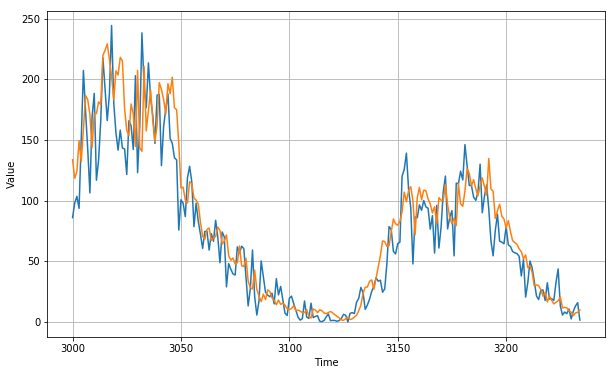

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

17.200783

<Figure size 432x288 with 0 Axes>

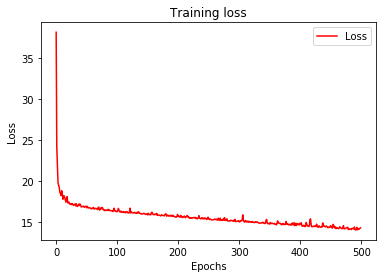

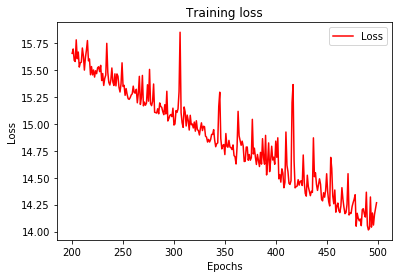

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [16]:
print(rnn_forecast)

[133.66956   118.44618   123.94288   149.37372   132.1507    158.67552
 186.57404   183.15372   170.91133   143.41214   171.53203   171.6176
 181.3368    179.13113   219.70502   223.87602   229.18105   216.4475
 202.46645   183.03566   206.92567   203.39784   218.02864   215.0633
 175.79053   157.62498   153.6005    179.65541   171.4688    144.56087
 207.22263   143.53882   140.59871   210.62527   157.3957    174.46758
 191.23517   166.01436   148.76433   162.2442    197.20625   191.6259
 183.32889   171.31366   196.31964   188.07806   201.68144   176.37686
 174.87968   146.82726   110.3828    111.07044   100.58519    98.03499
 115.66548   113.88579   102.1737    100.32114    97.04212    82.12204
  70.56034    68.13744    76.23554    77.40599    67.156425   69.152985
  70.5005     78.19954    75.387596   64.12322    66.69627    71.77026
  54.77929    50.86863    52.713852   47.75466    48.801346   62.65639
  46.217537   45.839733   52.51894    33.652153   28.409313   27.142242
  42.745